# Features 

Nicolly Kobayashi  
Renato Watanabe


## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import libraries

In [ ]:
!pip install hickle
import hickle
import pandas as pd
import numpy as np
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator
from skimage.morphology import reconstruction, diameter_opening
import h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49 kB 2.7 MB/s 
     |████████████████████████████████| 2.9 MB 14.4 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


## Load files with the EMG signals RMS

In [ ]:
matriz_p_list =  hickle.load("/content/drive/MyDrive/dicionario/matriz_p_cut.h5")
matriz_rms_list =  hickle.load("/content/drive/MyDrive/dicionario/matriz_rms_cut.h5")
f_list =  hickle.load("/content/drive/MyDrive/dicionario/f_list_teste.hkl")

## Artifact removal functions

Two measures are computed to identify which signals are artifacts: $P_l$ (low frequency) and $P_{line}$ (power-line frequency and its first four harmonics). They were computed by:

$P_l = \frac{\int_0^{12} S(f)\,df}{\int_0^{\infty} S(f)\,df} \approx  \frac{\displaystyle\sum_{i=0}^{a}S(i)}{\displaystyle\sum_{i=0}^{N-1}S(i)}$

$P_{line} = \frac{(S(50)+S(100)+S(150)+S(200)+S(250))\Delta f}{\int_0^{\infty} S(f)\,df} \approx = \frac{S(50)+S(100)+S(150)+S(200)+S(250)}{\displaystyle\sum_{i=0}^{N-1}S(i)}$

where $a$ is the frequency closer to 12 Hz and $N$ is the number of discrete frequencies computed by the Welch method.

In [ ]:
def pl_pline(matriz_p, f):
  matriz_pl = matriz_p[:,:,f<=12].sum(axis=2)/matriz_p.sum(axis=2)

  matriz_pline = (matriz_p[:,:,np.abs(f-50)<2].sum(axis=2)+matriz_p[:,:,np.abs(f-100)<2].sum(axis=2) +
                  matriz_p[:,:,np.abs(f-150)<2].sum(axis=2)+matriz_p[:,:,np.abs(f-200)<2].sum(axis=2) +
                  matriz_p[:,:,np.abs(f-250)<2].sum(axis=2))/matriz_p.sum(axis=2)
  
  return matriz_pl, matriz_pline

Only a subset of the channels are used to compute the thresholds that will define if a channel is an artifact. This subset, named ref, is the subset of channels that follow these conditions:

$\text{ref} = \left\{\begin{array}{l}\left|P_l(\text{ref}) - \text{median}(P_l)\right| < 1.5IQR(P_l)\\ 
\left|P_{line}(\text{ref}) - \text{median}(P_{line}) \right| < 1.5IQR(P_{line})
 \end{array}\right.$

where IQR stands for interquartile range

In [ ]:
def comp_ref(p) :
  median = np.median(p)
  q1 = np.quantile(p, q=0.25)
  q4 = np.quantile(p, q=0.75)
  iqr = q4 - q1
  
  ref_x = np.abs(p - median) < 1.5*iqr

  return ref_x

In [ ]:
def ref_funcao(matriz_pl, matriz_pline) :
  ref_pl = comp_ref(matriz_pl)
  ref_pline = comp_ref(matriz_pline)

  ref = np.logical_and(ref_pl, ref_pline)
  return ref

The criteria to decide whether a channel is an artifact is based on three thresholds.

If any of these conditions are not satisfied, the channel is considered an artifact and should be removed from further analysis.

$\text{Non-artifact} = \left\{\begin{array}{l} P_l < \text{thresh}_{l} \\                                              P_{line} < \text{thresh}_{line}\\                                               RMS > \text{thresh}_{RMS}\end{array}\right.$

In [ ]:
def thresh(p, k) :
  q1 = np.quantile(p, q=0.25)
  q4 = np.quantile(p, q=0.75)
  iqr = q4 - q1
  median = np.median(p)
  thresh = k * (median + 1.5*iqr)
  return thresh

The threshold for the $RMS$ is computed by:

$\text{thres}_{RMS} = \min\{\mu_A,\mu_B,\mu_C \} + k_2\max\{\sigma_A, \sigma_B, \sigma_C\}$ 

where $k_{2} = 0.2$, $\mu_A$, $\mu_B$, $\mu_C$ are the mean of the matrices $P_A$, $P_B$ and $P_C$, respectively, and $\sigma_A$, $\sigma_B$, $\sigma_C$ are the standard deviation of the matrices $P_A$, $P_B$ and $P_C$, respectively. The matrices $P_A$, $P_B$ and $P_C$ are built as follows. The array of HD-EMG has 9 rows and 14 columns. For the $i^{\text{th}}$ row and the $j^{th}$ column of the array:

$P_A[i,j] = [RMS[i-1,j,RMS[i+1,j]]$  
$P_B[i,j] = [RMS[i-1,j+1,RMS[i+1,j-1]]$  
$P_C[i,j] = [RMS[i+1,j+1,RMS[i-1,j-1]]$

i.e., these matrices have 9 rows, 14 columns and 2 layers deep.


In [ ]:
def Pa_Pb_Pc(matriz_rms):
  Pa = np.zeros((9, 14, 2))
  Pb = np.zeros((9, 14, 2))
  Pc = np.zeros((9, 14, 2))

  for c in np.arange(0,14):
    for l in np.arange(0,9):
      if c == 0:
        if l == 0:
          Pa[l,c,0] = 0
          Pa[l,c,1] = matriz_rms[l,c+1]
          Pb[l, c,:] = 0
          Pc[l,c,1] = matriz_rms[l+1,c+1]
          Pc[l,c,0] = 0
        elif l == 8:
          Pa[l,c,0] = 0
          Pa[l,c,1] = matriz_rms[l,c+1]
          Pb[l, c, 0] = 0
          Pb[l, c, 1] = matriz_rms[l-1,c+1]
          Pc[l, c,:] = 0
        elif l < 8 and l > 0:
          Pa[l,c, 0] = 0
          Pa[l,c, 1] = matriz_rms[l,c+1]
          Pb[l, c, 0] = 0
          Pb[l, c, 1] = matriz_rms[l-1,c+1]
          Pc[l, c, 0] = 0
          Pc[l, c, 1] = matriz_rms[l+1,c+1]
      elif c == 13:
        if l == 0:
          Pa[l, c, 0] = matriz_rms[l,c-1]
          Pa[l, c, 1] = 0
          Pb[l, c, 0] = matriz_rms[l+1,c-1]
          Pb[l, c, 1] = 0
          Pc[l, c, :] = 0
        elif l == 8:
          Pa[l, c, 0] = matriz_rms[l,c-1]
          Pa[l, c, 1] = 0
          Pb[l, c, :] = 0
          Pc[l, c, 0] = matriz_rms[l-1,c-1]
          Pc[l, c, 1] = 0
        elif l < 8 and l > 0 :
          Pa[l, c, 0] = matriz_rms[l,c-1]
          Pa[l, c, 1] = 0
          Pb[l, c, 0] = matriz_rms[l+1,c-1]
          Pb[l, c, 1] = 0
          Pc[l, c, 0] = matriz_rms[l-1,c-1]
          Pc[l, c, 1] = 0
      elif l == 0 and c != 0 and c != 13 :
        Pa[l, c, 0] = matriz_rms[l,c-1]
        Pa[l, c, 1] = matriz_rms[l,c+1]
        Pb[l, c, 0] = 0
        Pb[l, c, 1] = matriz_rms[l-1,c+1]
        Pc[l, c, 0] = 0
        Pc[l, c, 1] = matriz_rms[l-1,c-1]
      elif l == 8 and c != 0 and c != 13 :
        Pa[l, c, 0] = matriz_rms[l,c-1]
        Pa[l, c, 1] = matriz_rms[l,c+1]
        Pb[l, c, 0] = 0
        Pb[l, c, 1] = matriz_rms[l-1,c+1]
        Pc[l, c, 0] = 0
        Pc[l, c, 1] = matriz_rms[l-1,c-1]
      else:
        Pa[l, c, 0] = matriz_rms[l,c-1]
        Pa[l, c, 1] = matriz_rms[l,c+1]
        Pb[l, c, 0] = matriz_rms[l+1,c-1]
        Pb[l, c, 1] = matriz_rms[l-1,c+1]
        Pc[l, c, 0] = matriz_rms[l-1,c-1]
        Pc[l, c, 1] = matriz_rms[l+1,c+1]
  return Pa, Pb, Pc

In [ ]:
def mean_Pa_Pb_Pc(Pa, Pb, Pc):
  matriz_media_Pa = np.mean(Pa, axis=2)
  matriz_media_Pb = np.mean(Pb, axis=2)
  matriz_media_Pc = np.mean(Pc, axis=2)
  return matriz_media_Pa, matriz_media_Pb, matriz_media_Pc

def std_Pa_Pb_Pc(Pa, Pb, Pc):
  matriz_std_Pa = np.std(Pa, axis=2)
  matriz_std_Pb = np.std(Pb, axis=2)
  matriz_std_Pc = np.std(Pc, axis=2)
  return matriz_std_Pa, matriz_std_Pb, matriz_std_Pc

In [ ]:
def thresh_rms_funcao(matriz_media_Pa, matriz_media_Pb, matriz_media_Pc, matriz_std_Pa, matriz_std_Pb, matriz_std_Pc, ref):
  min_media = np.min([np.min(matriz_media_Pa[ref]), np.min(matriz_media_Pb[ref]), np.min(matriz_media_Pc[ref])])
  max_desvio_padrao = np.max([np.max(matriz_std_Pa[ref]), np.max(matriz_std_Pa[ref]), np.max(matriz_std_Pa[ref])]) #duvida são todos Pa msm?

  k2 = 0.2
  thresh_rms = min_media + k2*max_desvio_padrao
  return thresh_rms

In [ ]:
def channels_artifacts(matriz_pl, thresh_l, matriz_rms, thresh_rms, matriz_pline, thresh_line) :
  matriz_non_artifact = np.zeros((9, 14))
  matriz_non_artifact[np.logical_and(np.logical_and(matriz_pl<thresh_l, matriz_rms>thresh_rms), matriz_pline<thresh_line)] = 1
  return matriz_non_artifact

In [ ]:
def matrizes_nonArtifact_filtM(subj, movement, speed, session, matriz_p_list_teste, f, matriz_rms_list_teste, criterio):
  matriz_pl, matriz_pline = pl_pline(matriz_p_list_teste[subj, movement, speed, session], f)
  ref = ref_funcao(matriz_pl, matriz_pline)

  k1 = 7.1
  thresh_l = thresh(matriz_pl[ref].reshape(-1,1), k1)

  kline = 2.5
  thresh_line = thresh(matriz_pline[ref].reshape(-1,1), kline)

  Pa, Pb, Pc = Pa_Pb_Pc(matriz_rms_list_teste[subj, movement, speed, session])
  matriz_media_Pa, matriz_media_Pb, matriz_media_Pc = mean_Pa_Pb_Pc(Pa, Pb, Pc)
  matriz_std_Pa, matriz_std_Pb, matriz_std_Pc = std_Pa_Pb_Pc(Pa, Pb, Pc)

  thresh_rms = thresh_rms_funcao(matriz_media_Pa, matriz_media_Pb, matriz_media_Pc, matriz_std_Pa, matriz_std_Pb, matriz_std_Pc, ref)
  matriz_non_artifact = channels_artifacts(matriz_pl, thresh_l, matriz_rms_list_teste[subj, movement, speed, session], thresh_rms, matriz_pline, thresh_line)
  
  sem_artefatos = verifica_artefatos(matriz_non_artifact)
  if sem_artefatos :
    filt_M = filt_activation_map(matriz_rms_list_teste[subj, movement, speed, session], h=0.5)
    trial_ok = True
  else:
    trial_ok = True #criterio_de_remocao_de_trial(matriz_non_artifact, criterio)
    if trial_ok :
      M = matriz_rms_list_teste[subj, movement, speed, session]#interpolation(matriz_non_artifact, matriz_rms_list_teste[subj, movement, speed, session])
      filt_M = filt_activation_map(M, h=0.5)
    else :
      filt_M = []
  
  return matriz_non_artifact, filt_M, trial_ok

In [ ]:
def verifica_artefatos(matriz_non_artifact) :
  sem_artefatos = False
  soma = np.sum(matriz_non_artifact)
  if soma == 126 :
    sem_artefatos = True
  return sem_artefatos

In [ ]:
def criterio_de_remocao_de_trial(matriz_non_artifact, criterio) :
  canais_bons = 126 - criterio
  trial_ok = True
  soma = np.sum(matriz_non_artifact)
  if soma < canais_bons :
    trial_ok = False
  return trial_ok

## Interpolation of artifact channels


The estimation of the values of the channels that were considered as artifacts is performed by a piecewise linear interpolation considering three points around the missing point.  The three points are found by the Delaunay triangulation method. Below the triangles found by the Delaunay method are shown, as well as the good channels (green circles) and the artifact channels (red crosses). 



In [ ]:
def interpolation(matriz_non_artifact, matriz_rms):
  points = np.argwhere(matriz_non_artifact)
  artifact_points = np.argwhere(np.logical_not(matriz_non_artifact))
  tri = Delaunay(points)
  M = np.copy(matriz_rms)
  z = M[matriz_non_artifact.astype(bool)]
  interp = LinearNDInterpolator(tri, z, fill_value=0)
  X = np.arange(artifact_points[:,0].min(), 
                artifact_points[:,0].max()+1)
  Y = np.arange(artifact_points[:,1].min(), 
                artifact_points[:,1].max()+1)
  Xmesh, Ymesh = np.meshgrid(X, Y)  
  Z = interp(Xmesh, Ymesh)
  M[Xmesh,Ymesh] = Z
  #plt.triplot(points[:,1], points[:,0], tri.simplices)
  #plt.plot(points[:,1], points[:,0], 'og')
  #plt.plot(artifact_points[:,1], artifact_points[:,0], 'xr')
  #plt.show()
  return M

The peaks on the activation map were highlighted by using the reconstruction method followed by an opening.

In [ ]:
def filt_activation_map(M, h=20):
  image = M#/M.max()#gaussian_filter(I, 1)
  # seed = np.copy(image)
  seed = image - h
  mask = image

  dilated = reconstruction(seed, mask, method='dilation')
  filt_act_map = diameter_opening(dilated, 2)
  return filt_act_map

##Centro de massa

$CM_x = \frac{\sum_i M_ix_i}{\sum_i M_i}$

$CM_y = \frac{\sum_i M_iy_i}{\sum_i M_i}$

In [ ]:
def centro_de_massa(matriz) :
  somaMx = 0
  somaMy = 0
  somaM = 0

  for x in np.arange(1,15):
    for y in np.arange(1,10):

      somaMx = somaMx + matriz[y-1,x-1]*x
      somaMy = somaMy + matriz[y-1,x-1]*y
      somaM = somaM + matriz[y-1,x-1]

  CMx = somaMx/somaM
  CMy = somaMy/somaM
  
  return CMx, CMy

In [ ]:
def quadrantes(matriz) :
  i1 = []
  i2 = []
  i3 = []
  i4 = []
  i5 = []
  i6 = []
  for c in np.arange(0,14):
    for l in np.arange(0,9):
      if c <= 6 and l <= 2 :
        i1.append(matriz[l,c])
      elif c > 6 and l <= 2 :
        i2.append(matriz[l,c])
      elif c <= 6 and l > 2 and l <= 5 :
        i3.append(matriz[l,c])
      elif c > 6 and l > 2 and l <= 5 :
        i4.append(matriz[l,c])
      elif c <= 6 and l > 5 :
        i5.append(matriz[l,c])
      elif c > 6 and l > 5 :
        i6.append(matriz[l,c])
  mean_i1 = np.mean(i1)
  mean_i2 = np.mean(i2)
  mean_i3 = np.mean(i3)
  mean_i4 = np.mean(i4)
  mean_i5 = np.mean(i5)
  mean_i6 = np.mean(i6)
  return mean_i1, mean_i2, mean_i3, mean_i4, mean_i5, mean_i6

##Feature tables

The table contains the following information:

* CMx : centro de massa em x
* CMy : centro de massa em y
* I1, I2, I3, I4, I5, I6 : média dos quadrantes $I_i$
* Movement: the movement performed in the trial
* Subject: person who made the trial

In [ ]:
colunas= ['CMx','CMy','I1','I2','I3', 'I4', 'I5', 'I6', 'Movement','Subject']
caracteristicas = pd.DataFrame(columns=colunas)
file_image = h5py.File("/content/drive/MyDrive/dicionario/acmaps_nonorm_cut_nofilt.h5", "w")
movimentos= np.array(["cilinder", "point", "3digit", "thumbFlex", "index", "index_flex", "thumbAdd", "middle", "fist", "middle_flex", "pinch", "thumbExt", "disc"])
velocidade = ['fast', 'slow']
contador = 0
dataset = file_image.create_dataset(
        "image/", (1013,1,9,14), h5py.h5t.IEEE_F64BE)
meta_set = file_image.create_dataset(
    "meta/", (1013,1), h5py.h5t.STD_U64BE)
for subj in range(1,26) :
  for session in range(1,4) :
    for movement in movimentos :
      for speed in velocidade :
        try:  
            S = matriz_p_list[subj, movement, speed, session]
            f = np.linspace(0, 1024, S.shape[2])
           
            # matriz_non_artifact, filt_M, trial_ok = matrizes_nonArtifact_filtM(subj, movement, speed, session, matriz_p_list, f, matriz_rms_list, 40)
            trial_ok = True
            filt_M = matriz_rms_list[subj, movement, speed, session]
            if trial_ok:
                cmx, cmy = centro_de_massa(filt_M)
                caracteristicas.loc[contador,'CMx'] = cmx
                caracteristicas.loc[contador,'CMy'] = cmy
                caracteristicas.loc[contador,'Movement'] = movement
                i1, i2, i3, i4, i5, i6 = quadrantes(filt_M)
                caracteristicas.loc[contador,'I1'] = i1
                caracteristicas.loc[contador,'I2'] = i2
                caracteristicas.loc[contador,'I3'] = i3
                caracteristicas.loc[contador,'I4'] = i4
                caracteristicas.loc[contador,'I5'] = i5
                caracteristicas.loc[contador,'I6'] = i6
                caracteristicas.loc[contador,'Subject'] = subj
                dataset[contador,0,:,:] = filt_M
                meta_set[contador,0] = np.argwhere(movimentos==movement)[0][0]
                contador = contador + 1
        except KeyError:
            pass
    caracteristicas.to_csv('/content/drive/MyDrive/dicionario/caracteristicas_nonorm_cut_nofilt.csv', index=False)
caracteristicas
# dataset = (dataset - dataset[()].min(axis=0))/(dataset[()].max(axis=0)-dataset[()].min(axis=0))
file_image.close()

In [ ]:
file_image.close()

In [ ]:
caract = pd.read_csv('/content/drive/MyDrive/dicionario/caracteristicas_nonorm_cut_nofilt.csv')
caract

,CMx,CMy,I1,I2,I3,I4,I5,I6,Movement,Subject
0,7.050261,4.307841,4373.360320,3577.779205,4828.151024,3501.461601,1414.127391,1333.004479,cilinder,1
1,6.915705,5.680973,11.107965,23.245156,14.463653,16.086331,42.830479,17.088632,point,1
2,6.768928,5.812788,20.903648,62.817057,33.685063,38.465646,121.928849,39.340008,point,1
3,7.250993,5.229671,13.066266,18.585213,13.759849,14.289209,23.865808,14.404630,thumbFlex,1
4,7.263968,5.276537,8.953745,13.835927,9.904394,10.573882,18.377564,10.344240,thumbFlex,1
...,...,...,...,...,...,...,...,...,...,...
1008,6.764334,6.940233,210.915919,194.421056,350.226885,286.499245,1285.198756,1109.902057,middle_flex,25
1009,6.790595,6.943557,94.374880,70.115794,141.162059,111.850490,497.649618,469.918938,middle_flex,25
1010,8.207461,5.524549,71.276347,80.973102,66.572431,79.955979,86.921678,147.355966,pinch,25
1011,8.433199,5.592985,72.385886,98.437273,75.269806,95.375971,93.770922,189.742491,disc,25


(array([ 2.,  1.,  5.,  2.,  9., 26., 12., 12.,  1.,  4.]),
 array([1.33383453, 1.99229067, 2.65074681, 3.30920296, 3.9676591 ,
        4.62611525, 5.28457139, 5.94302753, 6.60148368, 7.25993982,
        7.91839596]),
 <a list of 10 Patch objects>)

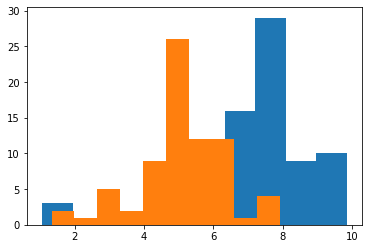

In [ ]:
import matplotlib.pyplot as plt
plt.hist(caract.query('Movement=="thumbFlex"')['CMx'])
plt.hist(caract.query('Movement=="thumbFlex"')['CMy'])

(array([ 1.,  2.,  1., 15., 19.,  9.,  0.,  0.,  0.,  4.]),
 array([2.89031778, 3.40192368, 3.91352959, 4.42513549, 4.93674139,
        5.4483473 , 5.9599532 , 6.47155911, 6.98316501, 7.49477092,
        8.00637682]),
 <a list of 10 Patch objects>)

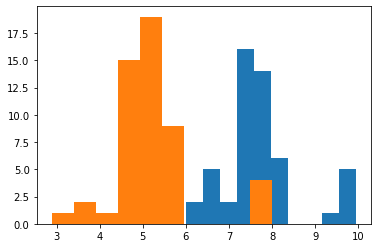

In [ ]:
plt.hist(caract.query('Movement=="pinch"')['CMx'])
plt.hist(caract.query('Movement=="pinch"')['CMy'])

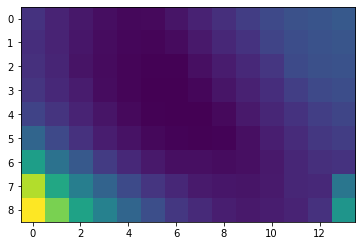

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(matriz_rms_list[1, 'middle_flex', 'slow', 3])